# Sacred Cycles
*Simulating Menstrual-esque Cycles Using Injected Estrogen*

In [43]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import sys
import math
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import collections as mc
from matplotlib import dates as mdates

import injectio
import injectables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Optimization

This constructs an optimization problem solving for optimal injection doses and times to fit a desired blood level profile.

In [66]:
def createInitialAndBounds(injections,
                           max_dose=np.inf,
                           time_bounds='midpoints'):
    # least_squares works on float parameters, so convert our injection dates
    # into float days.
    times = np.array([injectio.timeStampToDays(inj_date) for inj_date in injections.index][:-1])
    doses = injections["dose"][:-1].to_numpy()
    
    if time_bounds == 'midpoints':
        # Midpoint time bound handling:
        #   The first injection's minimum time bound is its same time
        #   The last injection's maximum time bound is the dummy injection time
        #   All other bounds are at the midpoints between the initial times
        midpoints = (times[1:] + times[:-1])/2.0
        #time_bounds = [(times[0], midpoints[0])] +\
        #TODO: revert this^ after figuring out zeroLevelsFromInjections flooring inconsistency
        time_bounds = [(times[0], np.nextafter(times[0], times[0]+1.0))] +\
                      [(l, r) for l,r in zip(midpoints[:-1], midpoints[1:])] +\
                      [(midpoints[-1], injectio.timeStampToDays(injections.index[-1]))]
    elif time_bounds == 'fixed':
        # least_squares doesn't have in-built capacity for fixed parameters,
        # and also requires each lower bound to be strictly less than each
        # upper bound. This is basically a hack to avoid requiring different
        # implementations for optimizing on doses+times vs just doses, keeping
        # the same array X of independent variables in both cases.
        time_bounds = [(T, np.nextafter(T, T+1.0)) for T in times]
    else:
        raise ValueError(f"'{time_bounds}' isn't a recognized input for time_bounds")
    
    dose_bounds = [(0.0, max_dose)]*len(doses)
    
    return np.concatenate((times, doses)),\
           list(zip(*time_bounds, *dose_bounds))


def createInjectionsTimesDoses(X_times_doses, X_injectables):
    """
    Create an injections DataFrame from the stacked X vector of doses and times
    used for curve fitting.
    
    X_injectables is the column of injectables corresponding to each injection.
    len(X_injectables) must == len(X_times_doses)/2.
    Scipy's optimization functions just pass around the X vector of minimzation
    parameters, but we need to reconstruct the full injections DataFrame to
    pass to injectio.calcInjections(...).
    
    This doesn't include the final dummy injection! Which is fine for the purpose
    of the optimization function, but the resulting injections Series won't
    behave as expected elsewhere."""
    n_inj = int(X_times_doses.size / 2)
    X_times_doses = np.append(X_times_doses, X_injectables).reshape((n_inj, 3), order='F')
    return injectio.createInjections(X_times_doses, date_unit='D')


# X is a 1D array of injection parameters we optimize on.
# Let i_n == len(injections)-1 (The last injection is always a zero-dose dummy
# point, so we don't optimize on it).
# Then, X is represented as i_n dose values followed by i_n corresponding dates
# in days.
# So, len(X) == 2*i_n.
def fTimesAndDoses(X_times_doses, X_injectables, target_x, target_y):
    injections = createInjectionsTimesDoses(X_times_doses, X_injectables)
    residuals = injectio.zeroLevelsAtMoments(target_x)
    injectio.calcInjections(residuals, injections, injectables.injectables)
    residuals -= target_y
    return residuals


def emptyResults():
    return defaultdict(lambda: {
        "injections_init": None,
        "X0": None,
        "bounds":None,
        "target": None,
        "result": None,
        "injections_optim": None,})

def initializeRun(injections_init,
                  target_x, target_y,
                  max_dose=np.inf, time_bounds='midpoints'):
    run = {}
    run["injections_init"] = injections_init
    run["X0"], run["bounds"] = createInitialAndBounds(
        injections_init,
        max_dose=max_dose,
        time_bounds=time_bounds)
    run["target"] = (target_x, target_y)
    run["result"] = None
    run["injections_optim"] = None
    return run

def runLeastSquares(run, max_nfev=20, **kwargs):
    X_injectables = run["injections_init"]["injectable"][:-1].values
    
    result = least_squares(
        fTimesAndDoses,
        run["X0"],
        args=(X_injectables,
              run["target"][0],
              run["target"][1]),
        bounds=run["bounds"],
        max_nfev=max_nfev,
        **kwargs)
    
    # Put the optimized X vector back into a DataFrame, and add back the final
    # zero injection that we dropped.
    injections_optim = pd.concat([
        createInjectionsTimesDoses(result.x, X_injectables),
        run["injections_init"].iloc[[-1]]])
    
    run["result"] = result
    run["injections_optim"] = injections_optim
    
    return result

def plotOptimizationRun(run):
    # Calculate levels at the initial and optimized moments of injection
    init_levels = injectio.calcInjections(
        injectio.zeroLevelsAtMoments(run["injections_init"].index),
        run["injections_init"],
        injectables.injectables)
    optim_levels = injectio.calcInjections(
        injectio.zeroLevelsAtMoments(run["injections_optim"].index),
        run["injections_optim"],
        injectables.injectables)
    
    ax = plt.gca()
    ax.plot(run["target"][0], run["target"][1], label="Target Curve")
    injectio.plotInjections(
        run["injections_init"],
        injectables.injectables,
        sample_freq='6H',
        label="Initial condition")
    injectio.plotInjections(
        run["injections_optim"],
        injectables.injectables,
        sample_freq='6H',
        label="Optimized solution")
    
    # Draw lines between the initial injections and the optimized injections
    init_points = [
        (mdates.date2num(T), level) for T,level in init_levels.items()]
    optim_points = [
        (mdates.date2num(T), level) for T,level in optim_levels.items()]

    lines = list(zip(init_points, optim_points))
    lc = mc.LineCollection(lines, linestyles='dotted', zorder=10)
    ax.add_collection(lc);
    ax.legend();

## Sine Wave

*try to fit blood levels to a sine wave curve*

In [46]:
sine_target_func = lambda T: int(T>=31.0) * (250.0 + 50.0*np.sin(0.5*T + 9.59)) +\
                             int(T<31.0)  * (8.0*T)
sine_start_t = pd.to_datetime("2020")
sine_target_x = pd.date_range(sine_start_t, sine_start_t + pd.to_timedelta(62.0, unit='D'), freq='6H')
sine_target_y = np.array([sine_target_func(injectio.timeDeltaToDays(T - sine_target_x[0])) for T in sine_target_x])

In [47]:
sine_results = emptyResults()

### Least Squares (Estradiol Cypionate, optimizing doses)

Works ok, doesn't find a great solution right now.

In [51]:
sine_results["ec_doses"] = initializeRun(
    injectio.createInjectionsCycle("ec", 62.0, '3D', start_date="2020"),
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='fixed')
runLeastSquares(
    sine_results["ec_doses"],
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1326e+05                                    3.64e+05    
       1              2         1.5926e+05      5.54e+05       8.81e-01       1.34e+05    
       2              3         6.5284e+04      9.40e+04       6.23e-01       4.77e+04    
       3              4         5.0633e+04      1.47e+04       2.48e-01       1.59e+05    
       4              5         4.5674e+04      4.96e+03       1.23e-01       6.88e+04    
       5              6         3.1094e+04      1.46e+04       5.04e-01       1.11e+05    
       6              7         2.7569e+04      3.53e+03       9.55e-02       2.09e+04    
       7              8         2.3228e+04      4.34e+03       1.34e-01       8.02e+04    
       8              9         2.1977e+04      1.25e+03       7.25e-02       2.41e+04    
       9             10         1.8710e+04      3.27e+03       1.99e-01       7.74e+04    

Optimized Injections:
                  dose injectable
2020-01-01      0.351         ec
2020-01-04      0.375         ec
2020-01-07      0.451         ec
2020-01-10      0.546         ec
2020-01-13      0.615         ec
2020-01-16      0.696         ec
2020-01-19      0.792         ec
2020-01-22      0.816         ec
2020-01-25      0.893         ec
2020-01-28      1.048         ec
2020-01-31      1.596         ec
2020-02-03      0.487         ec
2020-02-06      0.167         ec
2020-02-09      0.651         ec
2020-02-12      1.998         ec
2020-02-15      0.586         ec
2020-02-18      0.158         ec
2020-02-21      0.465         ec
2020-02-24      1.853         ec
2020-02-27      1.232         ec
2020-03-01      0.000         ec


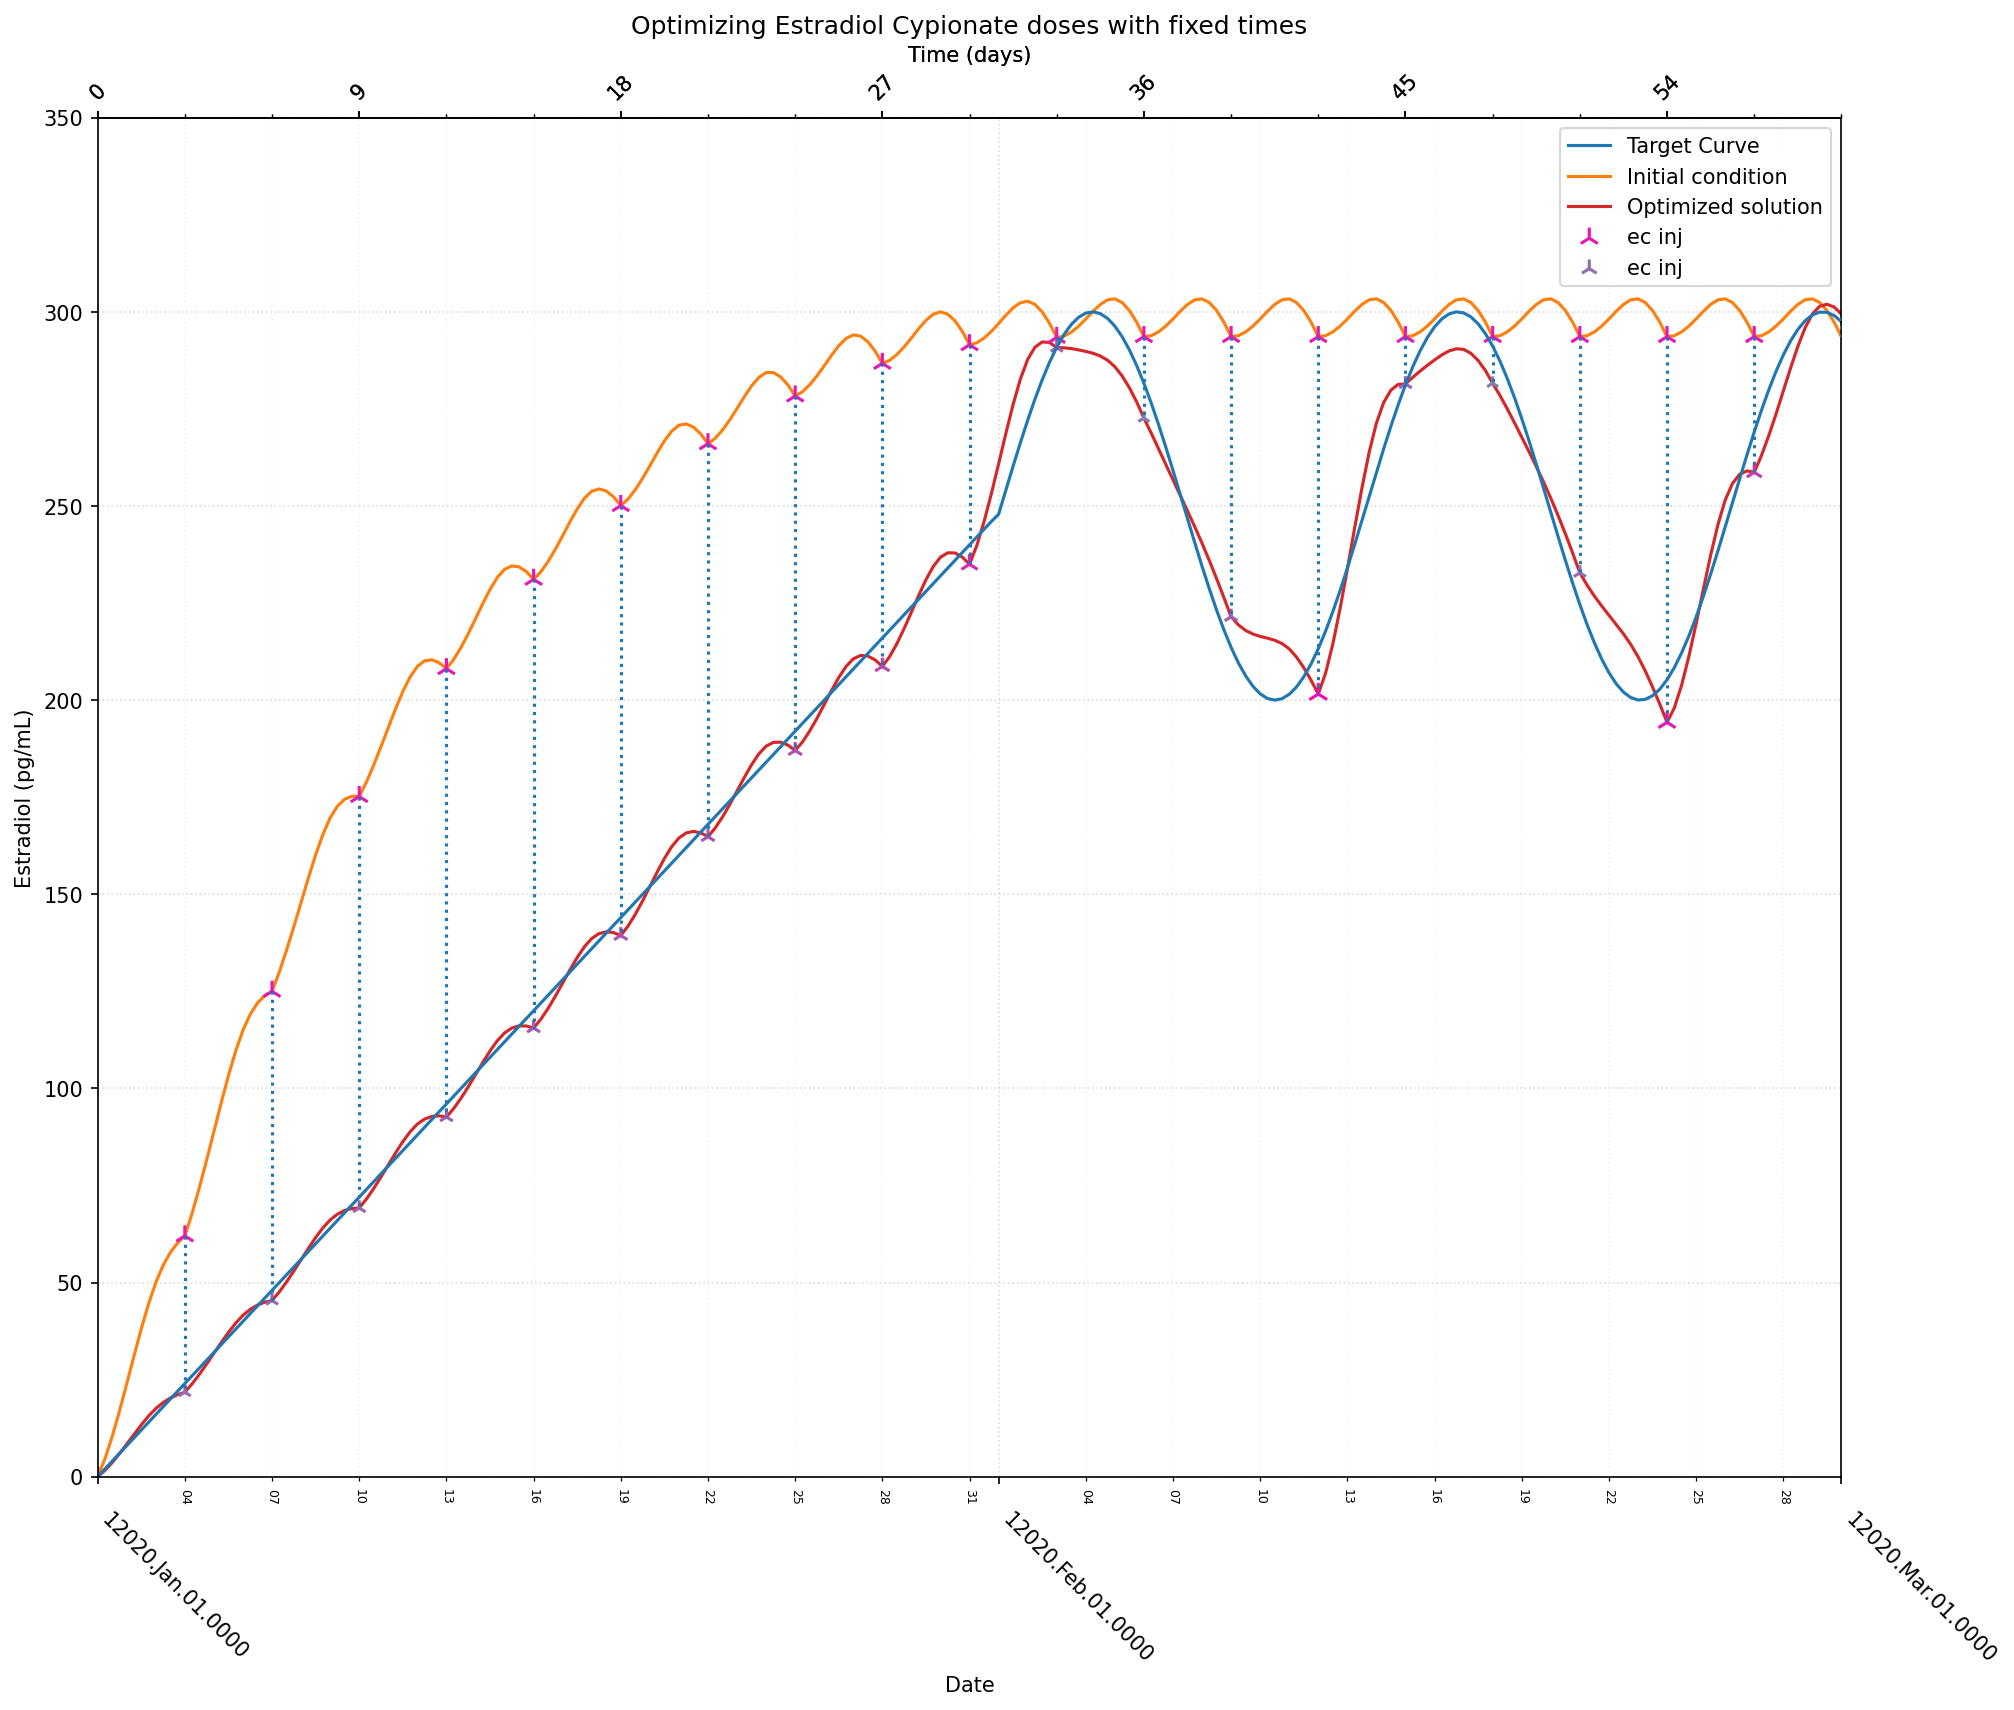

In [80]:
injectio.startPlot()
plt.title('Optimizing Estradiol Cypionate doses with fixed times')
plt.ylim(bottom=0, top=350)
plt.yticks(range(0, 351, 50))
plotOptimizationRun(sine_results["ec_doses"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", sine_results["ec_doses"]["injections_optim"])

### Least Squares (Estradiol Cypionate, Doses & Times)

This works awesome!

In [67]:
sine_results["ec_doses_and_times"] = initializeRun(
    injectio.createInjectionsCycle("ec", 62.0, '3D', start_date="2020"),
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='midpoints')
runLeastSquares(
    sine_results["ec_doses_and_times"],
    xtol=None,
    max_nfev=30,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1326e+05                                    3.64e+05    
       1              2         1.5722e+05      5.56e+05       8.84e-01       1.33e+05    
       2              3         6.2393e+04      9.48e+04       6.31e-01       4.50e+04    
       3              4         4.7266e+04      1.51e+04       2.55e-01       1.59e+05    
       4              5         3.3380e+04      1.39e+04       1.16e+00       1.42e+05    
       5              6         2.9351e+04      4.03e+03       1.05e-01       5.53e+04    
       6              7         2.0826e+04      8.53e+03       3.72e-01       7.01e+04    
       7              8         6.8378e+03      1.40e+04       1.68e+00       2.20e+04    
       8              9         2.1177e+03      4.72e+03       1.59e+00       1.52e+04    
       9             10         1.5409e+03      5.77e+02       2.73e-01       1.12e+04    

Optimized Injections:
                                     dose injectable
2020-01-01 00:00:00.000000000      0.360         ec
2020-01-04 04:59:29.986166400      0.414         ec
2020-01-07 09:52:10.399353600      0.478         ec
2020-01-10 11:38:55.338230400      0.567         ec
2020-01-13 10:57:05.229360000      0.626         ec
2020-01-16 09:57:18.551952000      0.690         ec
2020-01-19 08:14:47.801270400      0.746         ec
2020-01-22 05:16:08.513817600      0.815         ec
2020-01-25 02:33:43.561238400      0.875         ec
2020-01-27 22:04:30.540633600      0.941         ec
2020-01-30 19:39:34.989494400      1.180         ec
2020-02-01 19:27:51.674832000      1.033         ec
2020-02-07 12:00:00.000000000      0.006         ec
2020-02-09 20:26:42.227577600      1.038         ec
2020-02-12 00:43:57.541612800      1.401         ec
2020-02-14 04:29:16.554624000      0.937         ec
2020-02-16 12:02:56.949187199      0.000         ec
2020-02-22 04:00:18.101347200      1.044 

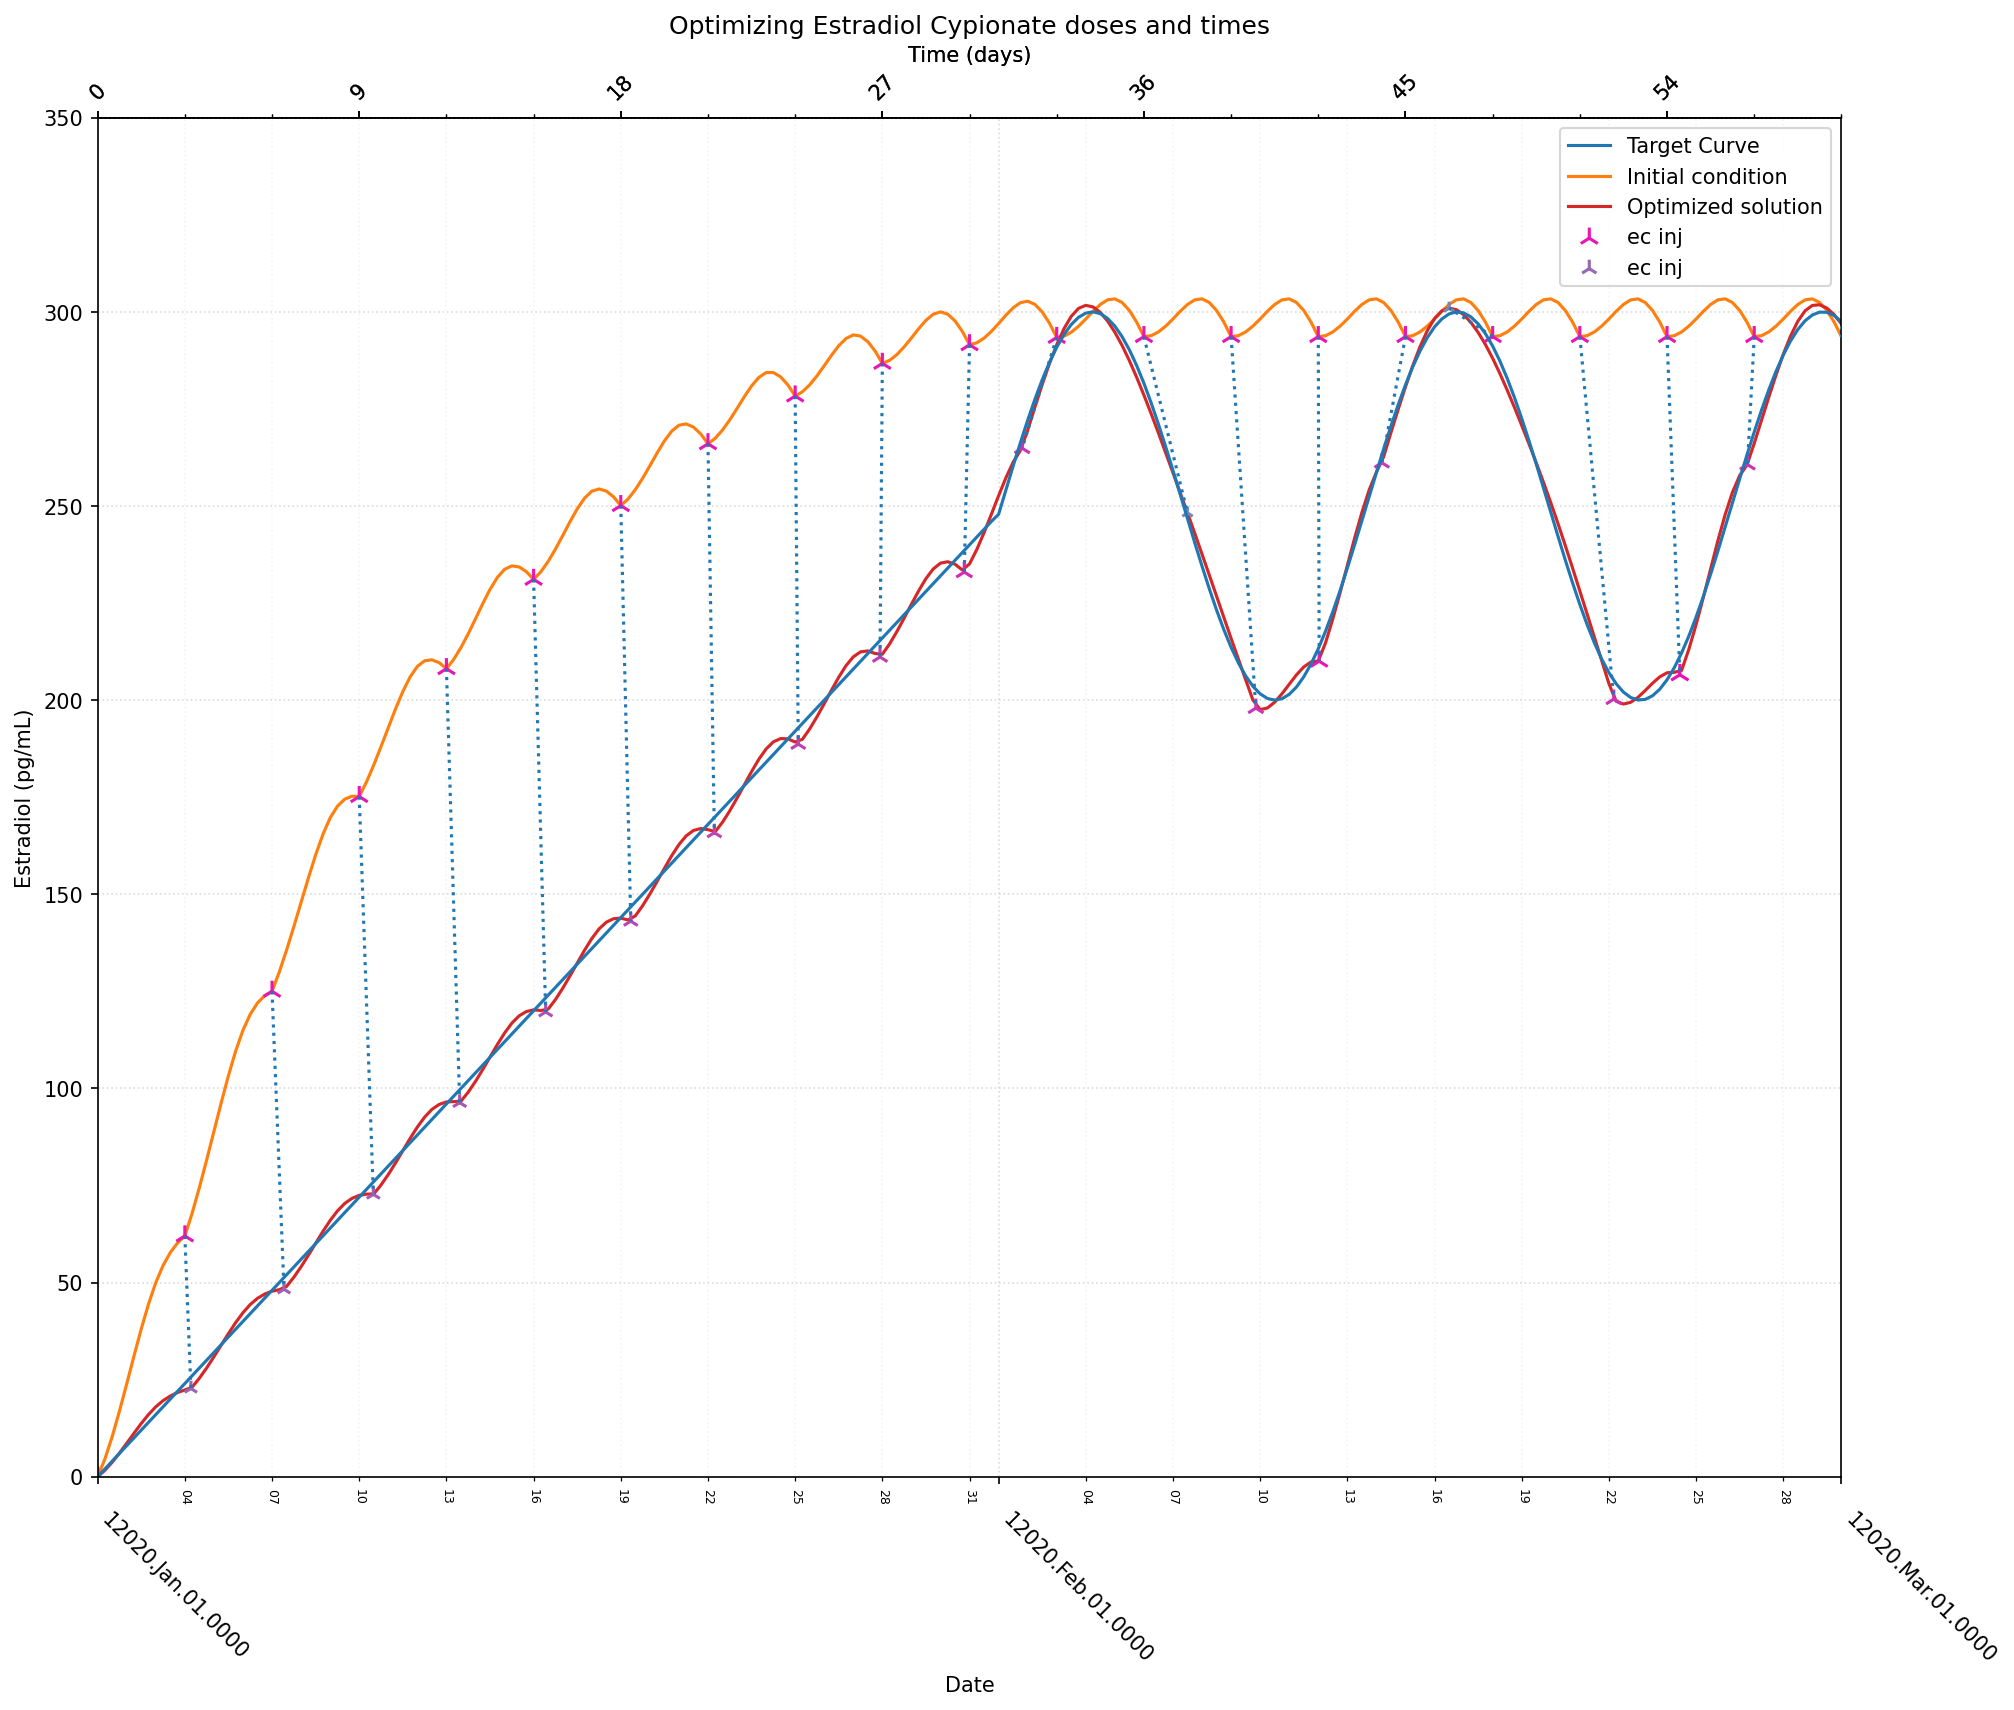

In [82]:
injectio.startPlot()
plt.title('Optimizing Estradiol Cypionate doses and times')
plt.ylim(bottom=0, top=350)
plt.yticks(range(0, 351, 50))
plotOptimizationRun(sine_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", sine_results["ec_doses_and_times"]["injections_optim"])

### Least Squares (Estradiol Valerate, Doses & Times)

At reasonable injection schedules, EV just really doesn't work for doing any kind of cycling. You can do it alright if you inject more frequently than the single-dose peak ($\tau \lt t_{max}$), but the smoother curve of Estradiol Cypionate makes it more suitable for this use.

In [84]:
sine_results["ev_doses_and_times"] = initializeRun(
    injectio.createInjectionsCycle("ev", 62.0, '1D', start_date="2020"),
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='midpoints')
runLeastSquares(
    sine_results["ev_doses_and_times"],
    max_nfev=25,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.2826e+06                                    7.29e+05    
       1              2         1.5084e+06      7.77e+06       2.79e+00       1.78e+05    
       2              3         1.9838e+05      1.31e+06       1.29e+00       5.94e+04    
       3              4         2.7900e+04      1.70e+05       5.27e-01       7.63e+04    
       4              5         2.2354e+04      5.55e+03       1.40e-01       1.62e+04    
       5              6         7.7297e+03      1.46e+04       1.78e-01       4.99e+04    
       6              7         4.3732e+03      3.36e+03       1.37e+00       3.16e+04    
       7              8         3.7305e+03      6.43e+02       4.07e-02       6.10e+03    
       8              9         1.9593e+03      1.77e+03       8.33e-02       1.38e+04    
       9             10         6.5607e+02      1.30e+03       1.14e+00       6.42e+03    

Optimized Injections:
                                     dose injectable
2020-01-01 00:00:00.000000000      0.116         ev
2020-01-02 09:41:24.632707200      0.074         ev
2020-01-03 04:00:15.948950400      0.081         ev
2020-01-04 07:32:57.439334400      0.143         ev
2020-01-05 11:59:56.020070400      0.157         ev
2020-01-06 11:45:32.671353600      0.075         ev
2020-01-06 17:15:40.053312000      0.107         ev
2020-01-07 16:56:54.795264000      0.154         ev
2020-01-08 16:17:43.186243200      0.202         ev
2020-01-09 14:22:42.887481600      0.166         ev
2020-01-10 14:48:10.445961600      0.268         ev
2020-01-11 21:51:45.557971200      0.319         ev
2020-01-13 04:27:47.340057599      0.336         ev
2020-01-14 09:48:31.038393600      0.293         ev
2020-01-14 22:42:22.396233600      0.114         ev
2020-01-15 19:20:30.419059200      0.357         ev
2020-01-17 00:44:23.522870400      0.404         ev
2020-01-18 04:01:12.330566400      0.310 

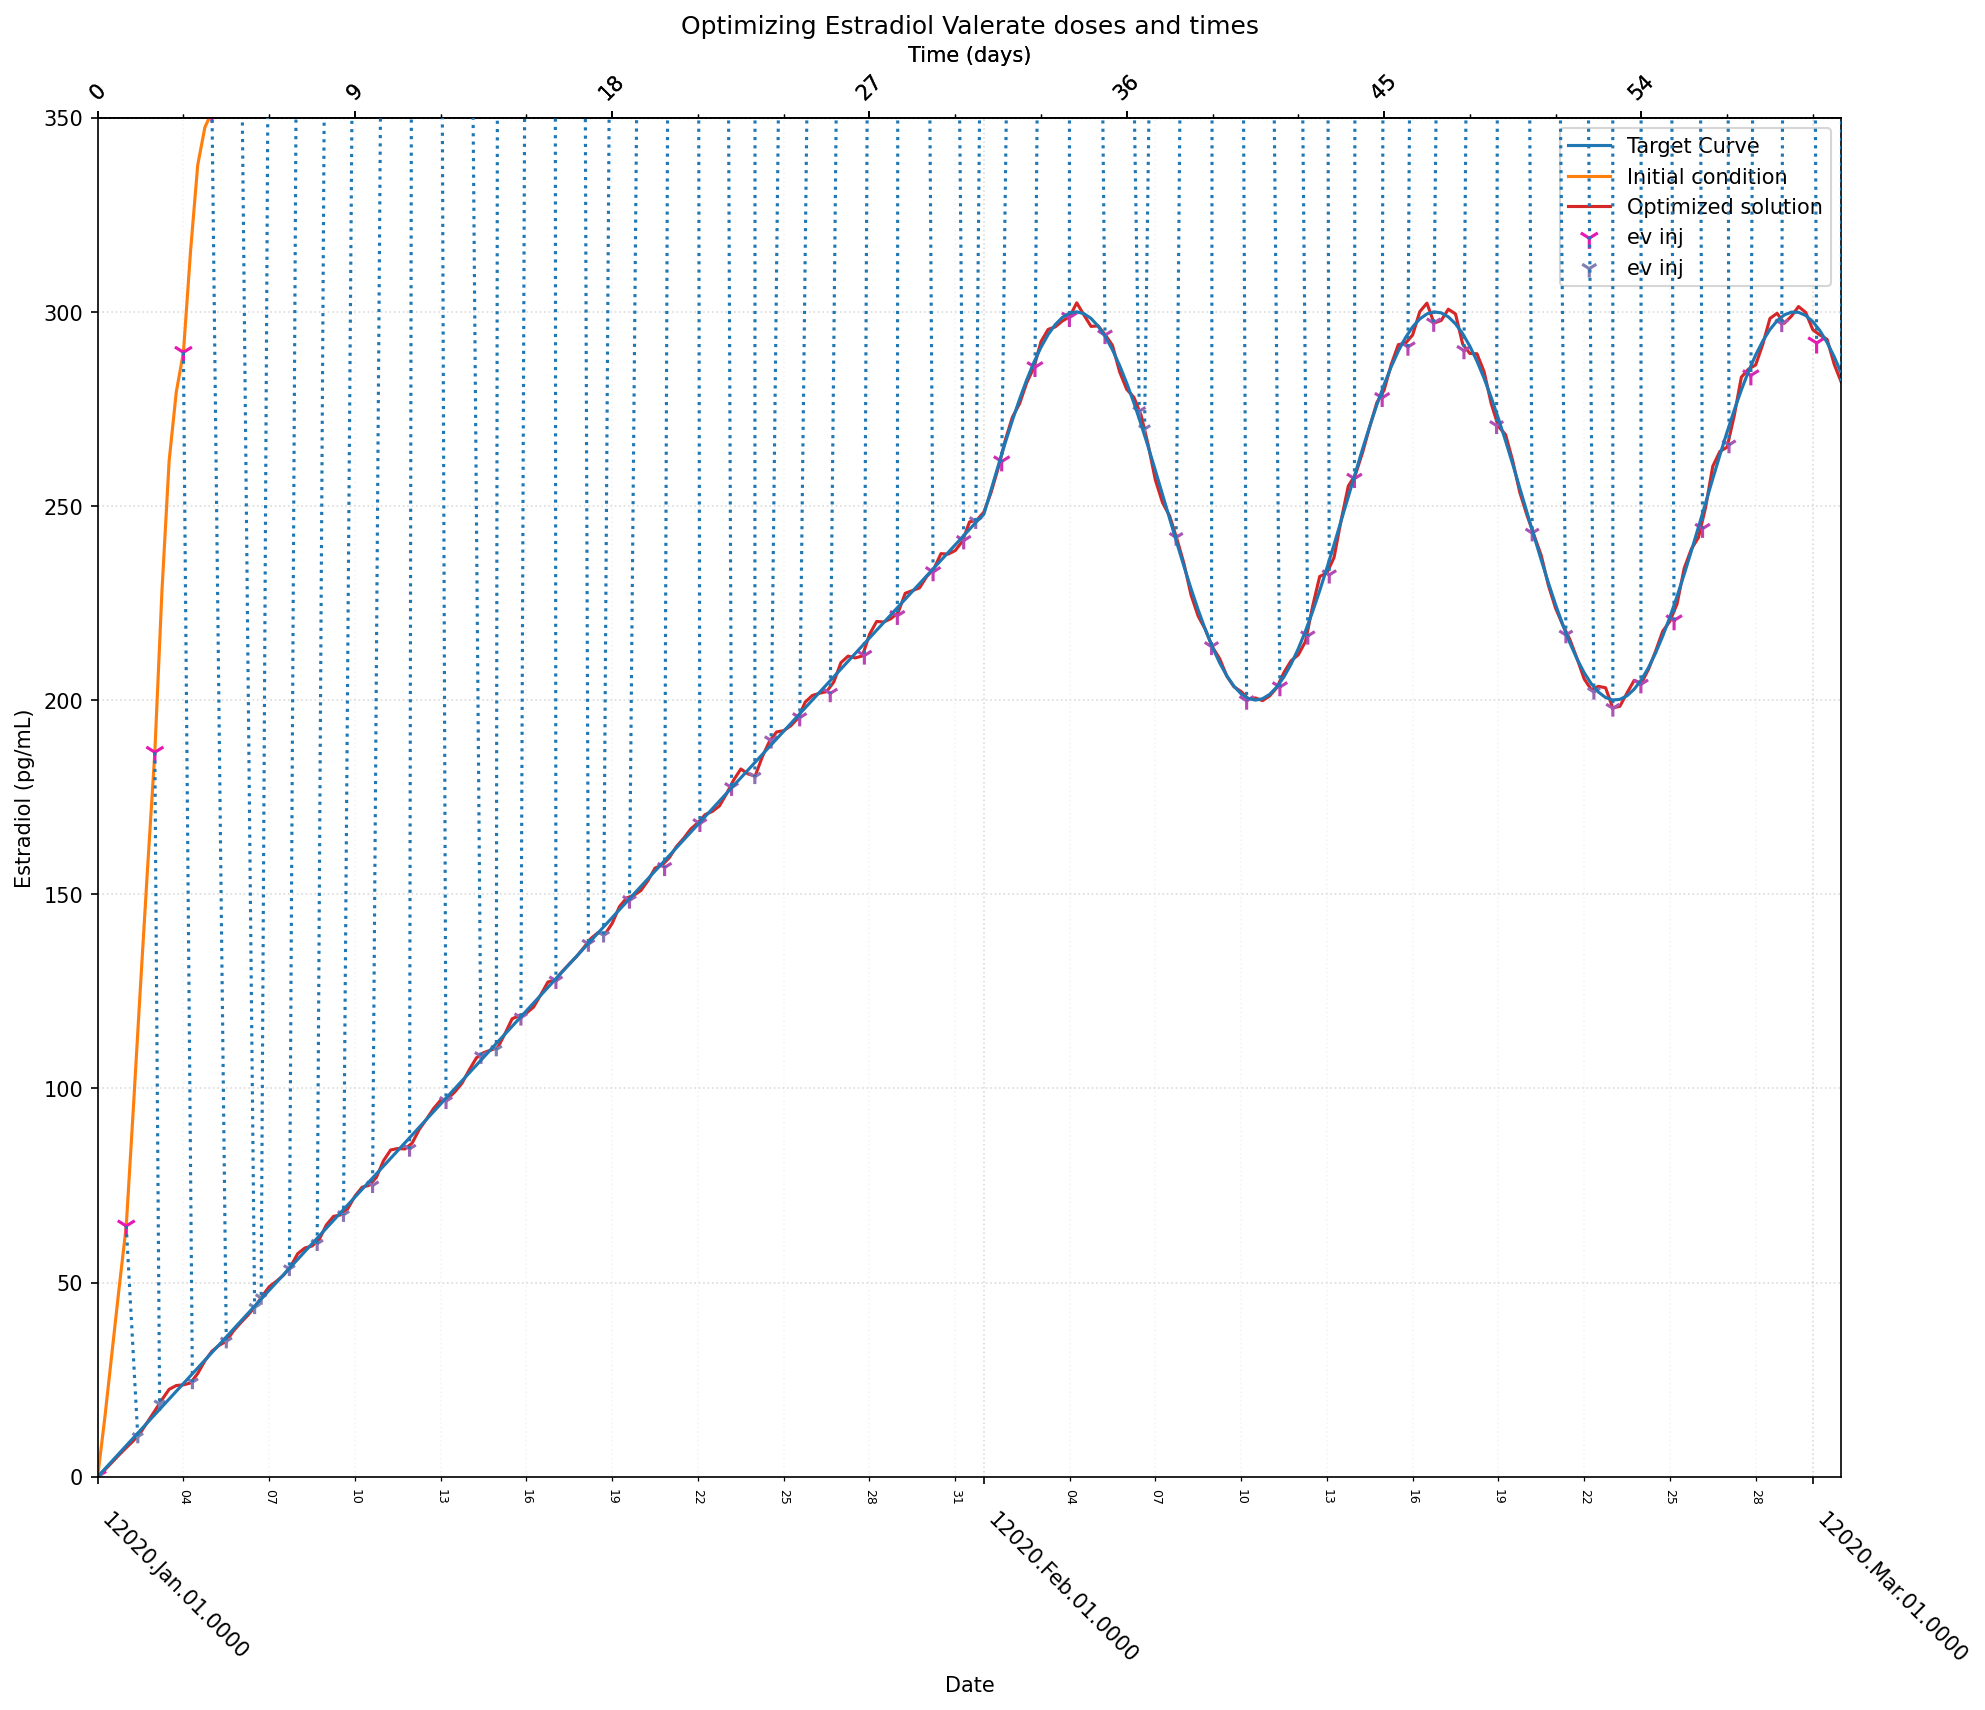

In [85]:
injectio.startPlot()
plt.title('Optimizing Estradiol Valerate doses and times')
plt.ylim(bottom=0, top=350)
plt.yticks(range(0, 351, 50))
plotOptimizationRun(sine_results["ev_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format,
                       "display.max_rows", sys.maxsize):
    print("Optimized Injections:\n", sine_results["ev_doses_and_times"]["injections_optim"])

### Step func (Estradiol Cypionate, optimize doses & times)

It's fun! This demonstrates the control theory intuition that, if desired, you can reach a steady state level more quickly by using several large injections to reach the target level and then reducing to a regular consistent dose. That doesn't mean it would be good for your body! But, looking purely at blood concentration levels, it's possible. The lsq solution here achieves a 150pg/mL change in level, steady-to-steady, in just 9 days (in comparison to 6 weeks for a linear, consistent increase in dose.

In [86]:
step_func = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (100.0)
step_target_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='6H')
step_target_y = np.array([step_func(T) for T in step_target_x])

In [87]:
step_results = emptyResults()

In [88]:
step_results["ec_doses_and_times"] = initializeRun(
    injectio.createInjectionsCycle("ec", 62.0, '3D'),
    step_target_x, step_target_y,
    max_dose=1.5,
    time_bounds='midpoints')
runLeastSquares(
    step_results["ec_doses_and_times"],
    xtol=None,
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3324e+06                                    5.22e+05    
       1              2         2.8834e+05      1.04e+06       1.10e+00       1.20e+05    
       2              3         1.3298e+05      1.55e+05       5.00e-01       5.47e+04    
       3              4         8.4492e+04      4.85e+04       4.35e-01       3.37e+04    
       4              5         7.4254e+04      1.02e+04       2.10e-01       1.92e+04    
       5              6         6.7087e+04      7.17e+03       1.63e-01       1.67e+04    
       6              7         6.3290e+04      3.80e+03       1.23e-01       1.22e+04    
       7              8         5.9641e+04      3.65e+03       1.26e-01       1.43e+04    
       8              9         5.7430e+04      2.21e+03       9.08e-02       9.80e+03    
       9             10         5.5026e+04      2.40e+03       1.13e-01       1.27e+04    

Optimized Injections:
                                     dose injectable
1970-01-01 00:00:00.000000000      1.485         ec
1970-01-03 17:51:52.166073600      0.145         ec
1970-01-07 01:23:45.262809600      0.234         ec
1970-01-10 00:27:22.556361599      0.413         ec
1970-01-12 22:09:44.779161600      0.344         ec
1970-01-16 00:20:13.740979200      0.285         ec
1970-01-18 23:19:25.568112000      0.293         ec
1970-01-22 02:03:59.275007999      0.303         ec
1970-01-25 03:34:15.658262400      0.328         ec
1970-01-29 05:51:57.445545600      1.244         ec
1970-01-30 19:06:50.827881600      1.492         ec
1970-02-02 10:20:51.811612800      0.723         ec
1970-02-06 02:21:11.551363200      0.817         ec
1970-02-08 23:18:24.669763200      0.936         ec
1970-02-11 21:24:28.618905600      0.813         ec
1970-02-15 00:01:31.651392000      0.755         ec
1970-02-18 00:11:20.145292799      0.800         ec
1970-02-21 01:04:19.968902400      0.828 

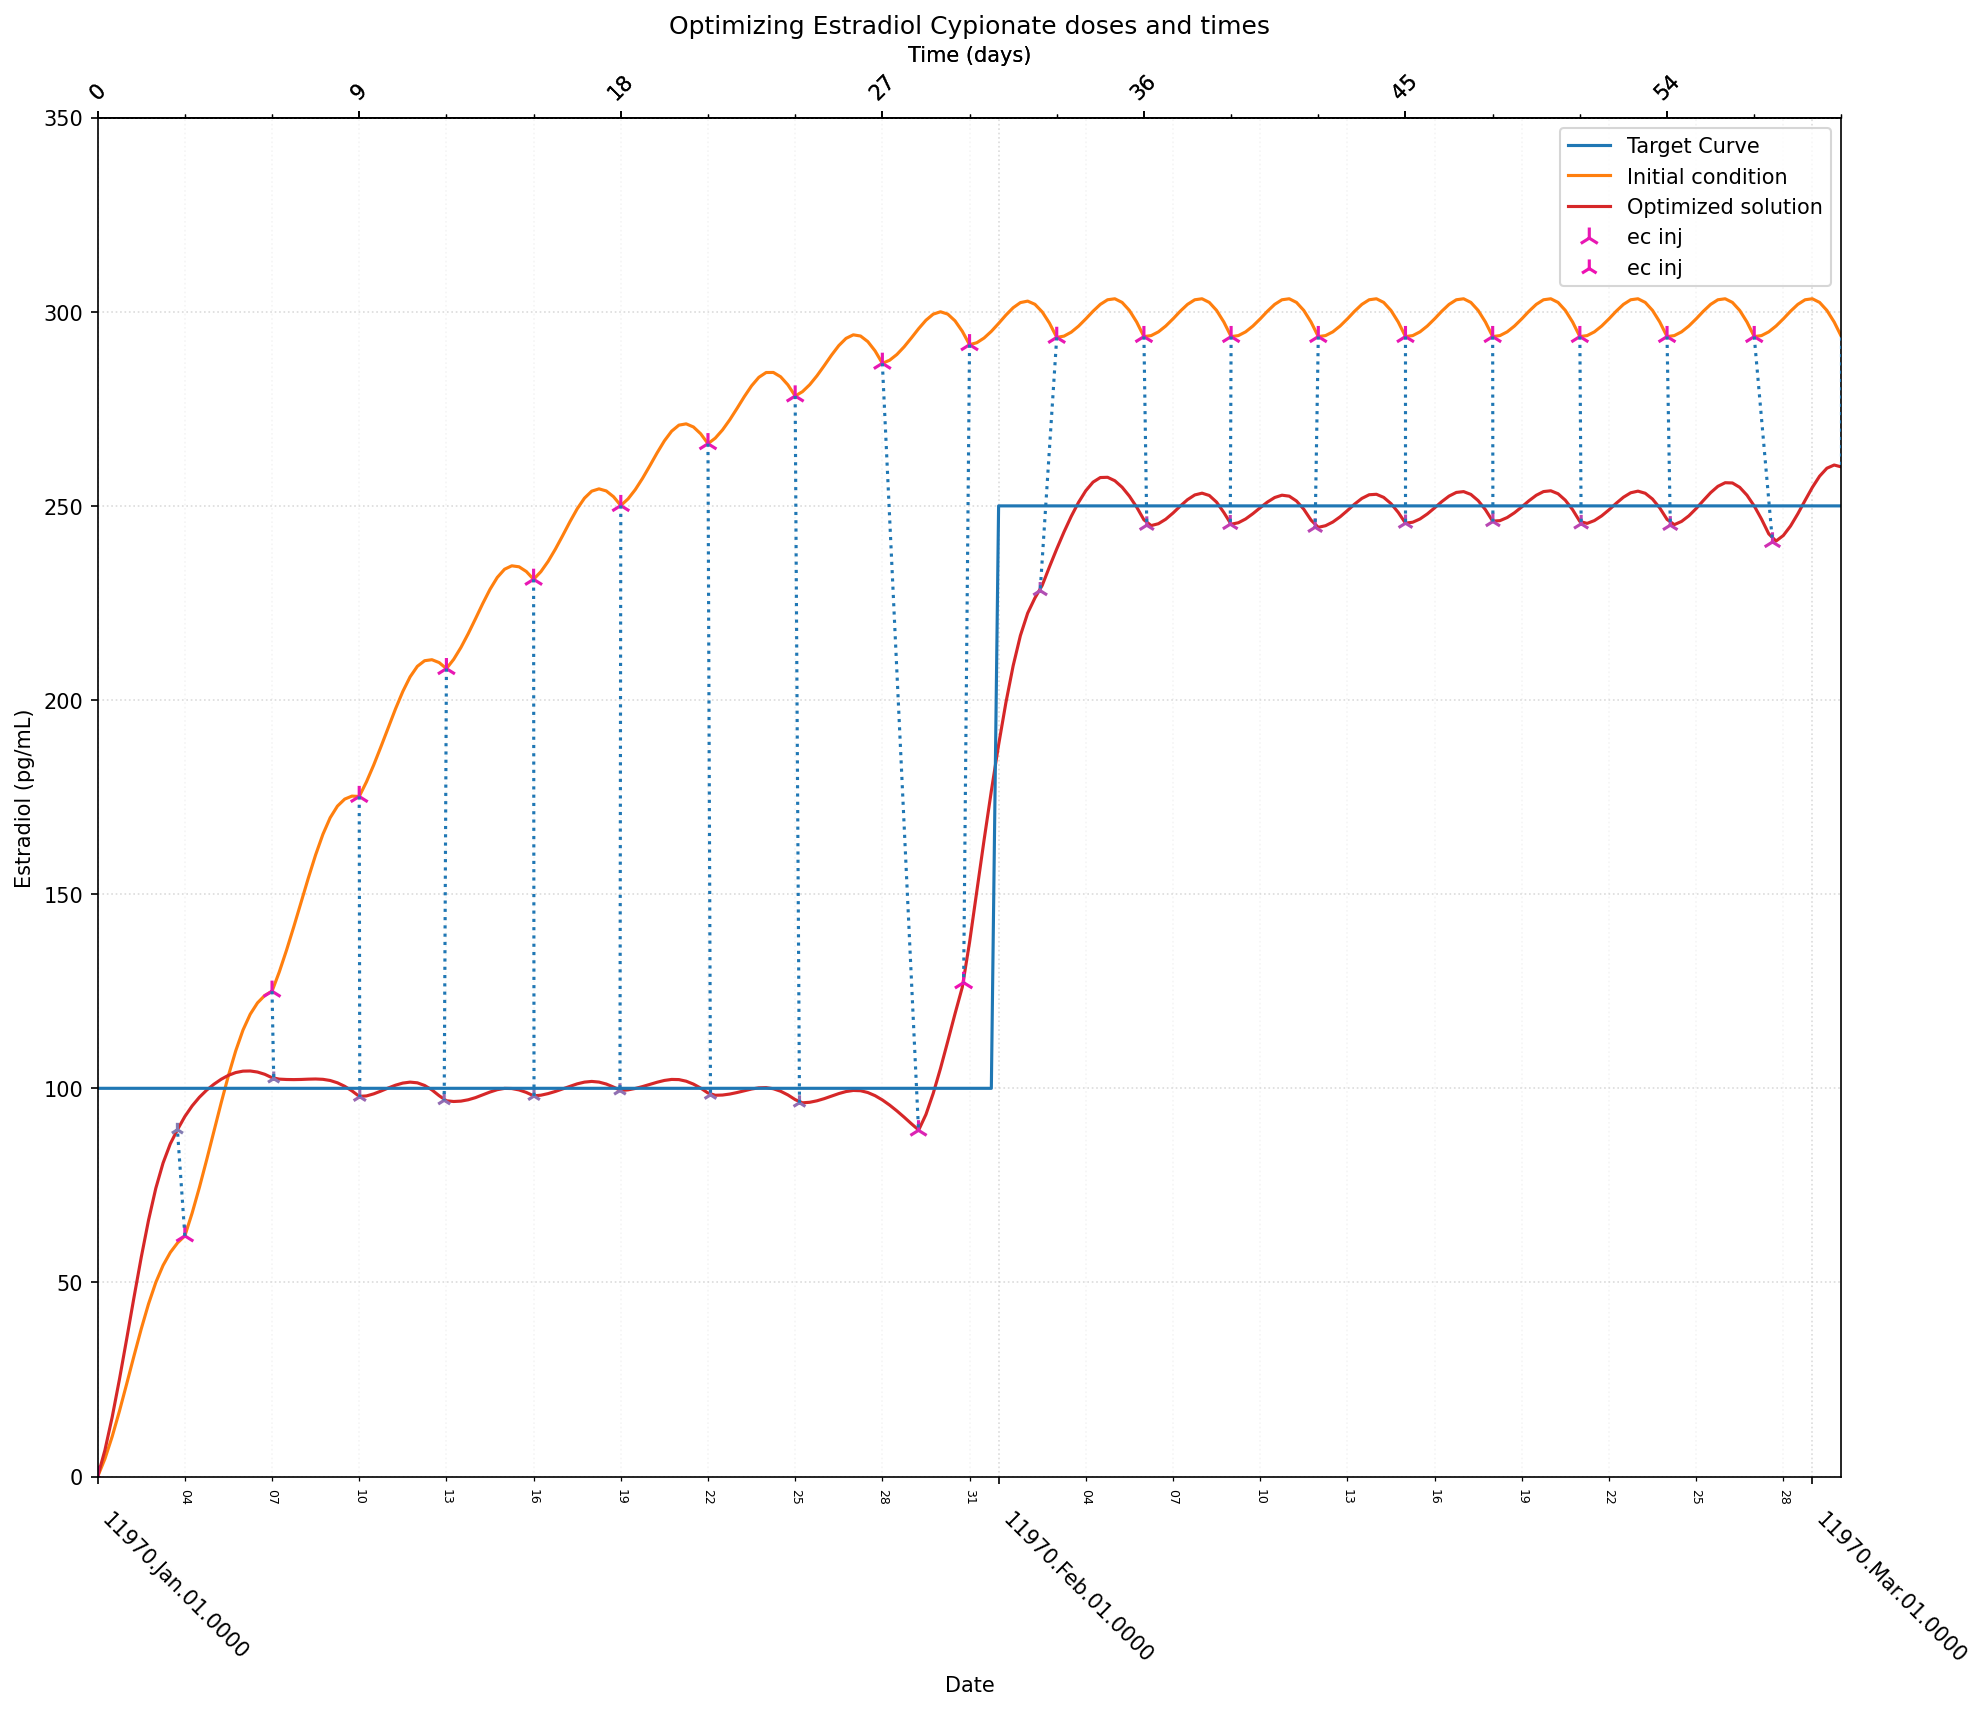

In [89]:
injectio.startPlot()
plt.title('Optimizing Estradiol Cypionate doses and times')
plt.ylim(bottom=0, top=350)
plt.yticks(range(0, 351, 50))
plotOptimizationRun(step_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", step_results["ec_doses_and_times"]["injections_optim"])